In [1]:
!pwd

/content


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [3]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

100% 2.58G/2.59G [00:19<00:00, 224MB/s]
100% 2.59G/2.59G [00:19<00:00, 143MB/s]


In [4]:
!unzip /content/ham1000-segmentation-and-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: masks/ISIC_0029321_segmentation.png  
  inflating: masks/ISIC_0029322_segmentation.png  
  inflating: masks/ISIC_0029323_segmentation.png  
  inflating: masks/ISIC_0029324_segmentation.png  
  inflating: masks/ISIC_0029325_segmentation.png  
  inflating: masks/ISIC_0029326_segmentation.png  
  inflating: masks/ISIC_0029327_segmentation.png  
  inflating: masks/ISIC_0029328_segmentation.png  
  inflating: masks/ISIC_0029329_segmentation.png  
  inflating: masks/ISIC_0029330_segmentation.png  
  inflating: masks/ISIC_0029331_segmentation.png  
  inflating: masks/ISIC_0029332_segmentation.png  
  inflating: masks/ISIC_0029333_segmentation.png  
  inflating: masks/ISIC_0029334_segmentation.png  
  inflating: masks/ISIC_0029335_segmentation.png  
  inflating: masks/ISIC_0029336_segmentation.png  
  inflating: masks/ISIC_0029337_segmentation.png  
  inflating: masks/ISIC_0029338_segmentation.png  
  inflating: masks/ISIC_0029339

In [5]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fe2l5525
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-fe2l5525
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=472f510884e2f0d71721ed28c58896b7d90feb3d91b73bf9638fca895082f5d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-hab3w9_b/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [6]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import imshow

In [7]:
def getDF(path):
  df = pd.read_csv(path)
  df['image'] = df['image'] +'.jpg'

  labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
  label_list=[]
  for index, row in df.iterrows():
      temp = list(row)
      del temp[0]
      index=np.argmax(temp)
      label=labels[index]
      label_list.append(label)
  df['label']= label_list
  df=df.drop(labels, axis=1)
  return df

In [90]:
def img_np_convert(df, image, h, w):

  sdir=image # main directory where data is stored
  height=h  # image height
  width=w   # image width
  channels=3  # number of coloor channels
  batch_size=40  # model batch size for training and evaluation
  img_shape=(height, width, channels)
  img_size=(height, width)

  gen=ImageDataGenerator() 

  df_gen=gen.flow_from_dataframe(df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)
  return df_gen

In [56]:
def downsample(df, count):
  result=[]
  df_group = df.groupby('label')
  for x in df['label'].unique():
    group = df_group.get_group(x)
    num = int(group['label'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0)
    else:
      s=group.sample(frac=1, axis=0)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

In [57]:
def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('label'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

In [58]:
df_path = '../content/GroundTruth.csv'
df = getDF(df_path)
print(df['label'].value_counts())

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64


In [59]:
label = df['label']
tain_size=0.7
valid_size = 0.1
test_size = 0.2
valid_test_split = valid_size / test_size

df_train, df_test_val, label_train, label_test_val = train_test_split(df, label, test_size=1-tain_size, shuffle=True, random_state=42)
df_val, df_test, label_val, label_test = train_test_split(df_test_val, label_test_val, test_size=valid_test_split, shuffle=True, random_state=42)

print(df_train.shape, label_train.shape)
print(df_test.shape, label_test.shape)
print(df_val.shape, label_val.shape)

(7010, 2) (7010,)
(1503, 2) (1503,)
(1502, 2) (1502,)


In [91]:
down_df_train = downsample(df_train, 1000)

In [92]:
majority = down_df_train['label'].value_counts()[0]

In [93]:
bal_df_train = oversample(down_df_train, majority)

In [95]:
h = 240
w = 240
image_path = r'../content/images'
train_gen = img_np_convert(bal_df_train, image_path, h, w)
test_gen = img_np_convert(df_test, image_path, h, w)
val_gen = img_np_convert(df_val, image_path, h, w)

Found 7000 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.


In [71]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')      
  ]

In [72]:
histories = {}

In [96]:
img_height = 240
img_width = 240
channels = 3
img_shape = (img_height, img_width, channels)

In [97]:
# Create the base model with EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')

In [ ]:
base_model.summary()

In [98]:
base_model.trainable = True

In [ ]:
base_model.summary()

In [100]:
Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )

In [101]:
prediction_layer = keras.layers.Dense(7, activation='softmax')

In [102]:
model = tf.keras.Sequential([
  base_model,
  Normalizator_layer,
  keras.layers.Dense(256, 
                     kernel_regularizer = regularizers.l2(l = 0.02),
                     activity_regularizer=regularizers.l1(0.01),
                     bias_regularizer=regularizers.l1(0.01), 
                     activation='relu'),
  keras.layers.Dropout(rate=.5, seed=42),
  prediction_layer                           
])

In [104]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 256)               327936    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 6,910,094
Trainable params: 6,845,479
Non-trainable params: 64,615
______________________________________

In [103]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [105]:
history = model.fit(x=train_gen, 
                    epochs=40, 
                    validation_data=val_gen, 
                    callbacks=get_callbacks())

Epoch 1/40
175/175 [==============================] - 145s 738ms/step - loss: 8.4141 - accuracy: 0.6536 - val_loss: 6.4466 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 2/40
175/175 [==============================] - 129s 733ms/step - loss: 4.8210 - accuracy: 0.8559 - val_loss: 3.9253 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 3/40
175/175 [==============================] - 127s 725ms/step - loss: 2.9257 - accuracy: 0.9110 - val_loss: 2.5937 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 4/40
175/175 [==============================] - 127s 726ms/step - loss: 1.7807 - accuracy: 0.9421 - val_loss: 1.6789 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 5/40
175/175 [==============================] - 127s 726ms/step - loss: 1.1135 - accuracy: 0.9616 - val_loss: 1.3718 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 6/40
175/175 [==============================] - 127s 727ms/step - loss: 0.7440 - accuracy: 0.9773 - val_loss: 0.9826 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 7/40
175/175 [==========================

In [106]:
histories['EfficientNetB1'] = history

(0.0, 1.0)

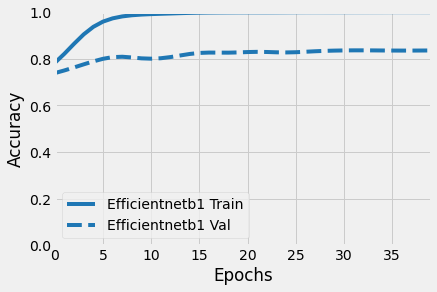

In [108]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 1])

In [109]:
model.evaluate(test_gen)

38/38 [==============================] - 16s 410ms/step - loss: 0.7781 - accuracy: 0.8290


[0.7780864834785461, 0.8290086388587952]

In [110]:
y_pred = model.predict(test_gen)

In [114]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

In [ ]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.48      0.30      0.37        47
     class 1       0.62      0.51      0.56        79
     class 2       0.50      0.44      0.47       149
     class 3       0.56      0.36      0.43        14
     class 4       0.44      0.50      0.47       170
     class 5       0.93      0.78      0.85      1016
     class 6       0.77      0.61      0.68        28

   micro avg       0.78      0.68      0.73      1503
   macro avg       0.61      0.50      0.55      1503
weighted avg       0.79      0.68      0.73      1503
 samples avg       0.68      0.68      0.68      1503



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


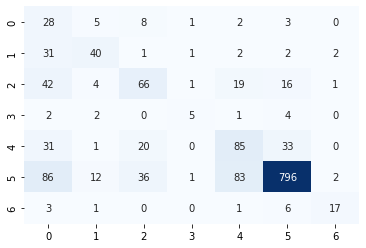

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)  